## Task 1. RANSAC Plane Fitting (3pt)

In this task, you are supposed to fit a plane in a 3D point cloud. You have to write a custom function to implement the RANdom SAmple Consensus (RANSAC) algorithm to achieve this goal.

<div style="text-align: center; display: flex; justify-content: center; gap: 0;">
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='/home/jithin/Desktop/Perception_HW2/Q1/demo_pc.png' width="400" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">Original Data</div>
  </div>
  <div style="text-align: center; margin: 0; padding: 0;">
    <img src='/home/jithin/Desktop/Perception_HW2/Q1/demo_pc_after_ransac.png' width="386" style="margin: 0; padding: 0;">
    <div style="margin: 0; padding: 0;">Data with the best fit plane marked in red</div>
  </div>
</div>

Use the following code snippet to load and visualize the demo point cloud provided by Open3D.

<div style="border: None; padding: 10px; background-color: 	#2F3F4F;">

  ```python
  import open3d as o3d

  # read demo point cloud provided by Open3D
  pcd_point_cloud = o3d.data.PCDPointCloud()
  pcd = o3d.io.read_point_cloud(pcd_point_cloud.path)

  # function to visualize the point cloud
  o3d.visualization.draw_geometries([pcd],
      zoom=1,
      front=[0.4257, -0.2125, -0.8795],
      lookat=[2.6172, 2.0475, 1.532],
      up=[-0.0694, -0.9768, 0.2024])

In [333]:
# Import Necessary Libraries
import open3d as o3d
from mpl_toolkits import mplot3d
import numpy as np
import math
import random
import matplotlib.pyplot as plt


<span style="color: red;">**Note:**</span> If you use the RANSAC API in existing libraries instead of your own implementation, you will only get 60% of the total score.
__________________________________________________________________________________________________________________________________________
Lets understand a sample point cloud from Open3D's data repository

Number of points: 113662
First 5 points:
 [[1.16796875 1.01803279 0.96484375]
 [1.16845131 1.01953125 0.96484375]
 [1.16796875 1.02158833 0.96484375]
 [1.16796875 1.01953125 0.96634495]
 [1.16796875 1.03289878 0.95703125]]
First 5 colors:
 [[0.49803922 0.45882353 0.41568627]
 [0.49803922 0.45882353 0.41568627]
 [0.49803922 0.45882353 0.41568627]
 [0.49803922 0.45882353 0.41568627]
 [0.         0.         0.        ]]
Downsampled number of points: 2756


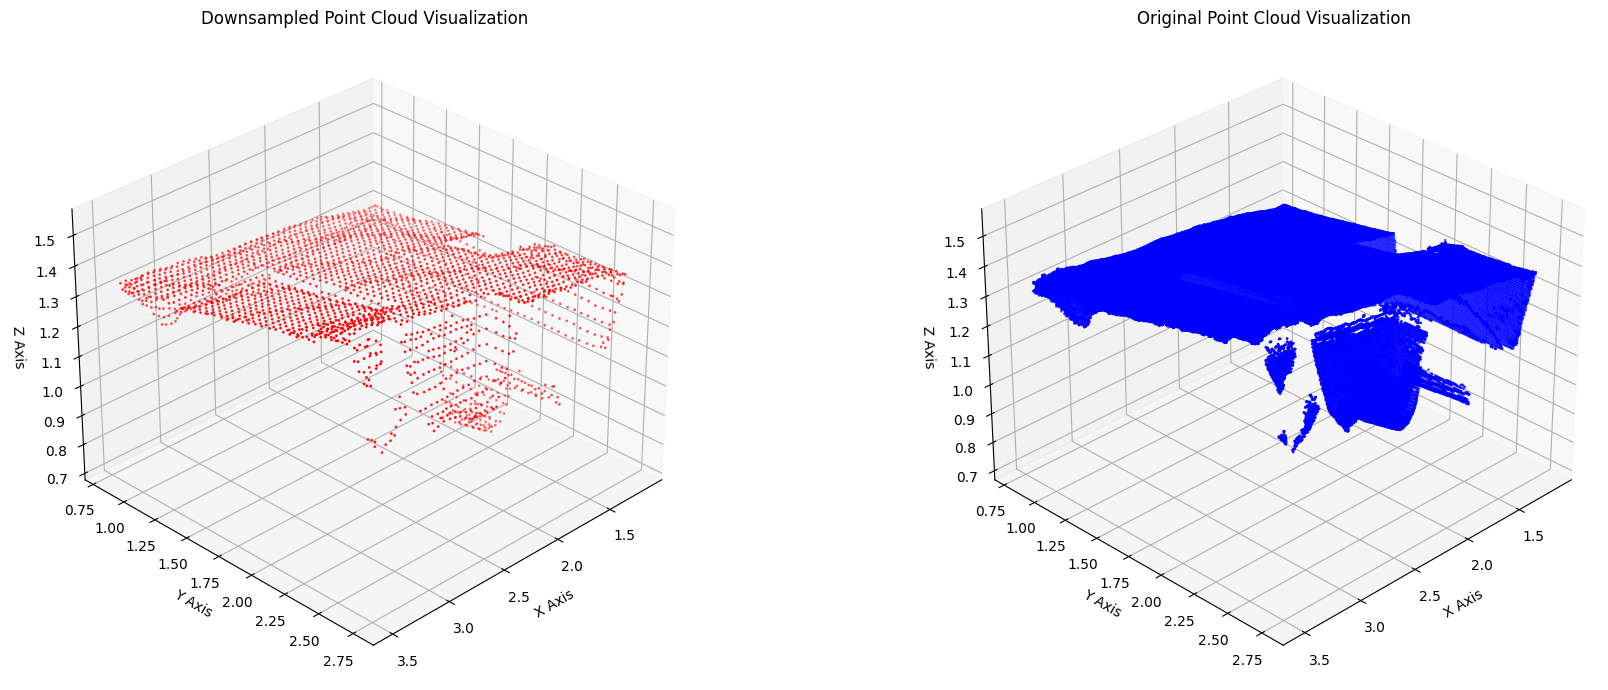

In [334]:
# 1. Load a sample point cloud from Open3D's data repository
pcd_point_cloud = o3d.data.PCDPointCloud()

# 2. Read the point cloud from the provided path
pcd_original = o3d.io.read_point_cloud(pcd_point_cloud.path)

# 3. Convert the point cloud's points to a NumPy array
pcd = np.asarray(pcd_original.points)

# 4. Print basic information
print(f"Number of points: {pcd.shape[0]}")
print("First 5 points:\n", pcd[:5])

# 5. Check and print color information
if pcd_original.has_colors():
    colors = np.asarray(pcd_original.colors)
    print("First 5 colors:\n", colors[:5])
else:
    print("No color information found.")

# 6. Downsample the point cloud (To better visualize the pcd)
voxel_size = 0.05
downsampled_pcd = pcd_original.voxel_down_sample(voxel_size=voxel_size)
downsampled_pcd_np = np.asarray(downsampled_pcd.points)
print(f"Downsampled number of points: {downsampled_pcd_np.shape[0]}")

# 7. Visualize Downsampled and Original pcd side by side using Matplotlib
# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 7))  # Increased width for better side-by-side display

# Left subplot: Downsampled Point Cloud
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(downsampled_pcd_np[:, 0], downsampled_pcd_np[:, 1], downsampled_pcd_np[:, 2],
           s=1, c='r', marker='o')
ax1.set_title("Downsampled Point Cloud Visualization")
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.view_init(elev=30, azim=45)  # Adjust view angle for better visualization

# Right subplot: Original Point Cloud
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(pcd[:, 0], pcd[:, 1], pcd[:, 2],
           s=1, c='b', marker='o')
ax2.set_title("Original Point Cloud Visualization")
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis")
ax2.view_init(elev=30, azim=45)  # Adjust view angle for consistency

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


In [335]:

iterations=10000



**Answer:** In the given question we have to fit a plane to the 3D point clouds. For defining a plane we need the normal vector to the plane and distance from the origin. Lets create some helper functions.


In [336]:
# Plane Equation: ax+by+cz+D=0; a=p2-p1; b=p3-p1

def plane(Init, debuging_mode = debuging_mode):
        
    p1, p2, p3 = Init
    v1 = p2 - p1
    v2 = p3 - p1
    N = np.cross(v1, v2)
    if np.linalg.norm(N) == 0:
        return None
    a, b, c = N
    D = -np.dot(N, p1)
    
    return a,b,c,D

Now we have to calculate the distance from the plane using:
$$
\text{dist} = \frac{|ax + by + cz + d|}{\sqrt{a^2 + b^2 + c^2}}
$$

In [337]:
def distance(a,b,c,D,pcd,debuging_mode = debuging_mode):
    Numerator=np.abs(a*pcd[:,0]+b*pcd[:,1]+c*pcd[:,2]+D)
    Denominator=np.sqrt(a**2 + b**2 + c**2)
    dist=Numerator/Denominator
    return dist


In [338]:
# Now we have to see how many inlier points are available wrt the plane that we defined

def inlier(a,b,c,D,pcd,debuging_mode = debuging_mode):
    
   '''This function identifies the inlier points—those that lie close to the plane within a specified distance threshold.
      -Compute Distances: Uses the previously defined distance function to calculate the distance of each point from the plane.
      -Thresholding: np.where(np.abs(dist) <= 0.05): Finds the indices of points where the absolute distance is less than or equal to 0.05 units.
      -Extract Inliers: Selects the points corresponding to these indices as inliers.
   '''
   # Compute distances of all points to the plane
   distances = distance(a, b, c, D, pcd)
   
   index = np.where(distances <= 0.05)[0]
   inliers = pcd[index]
   
   if debuging_mode:
      print("___________________________________________________")
      print(inliers)
      print(inliers.shape)
      print("___________________________________________________")
      
   return inliers



General RANSAC Algorithm:

1. Randomly choose **<span style="color:red;">s</span>** samples. Typically **<span style="color:red;">s</span>** is the minimum samples to fit a model.

2. Fit the model to the randomly chosen samples.

3. Count the number **<span style="color:red;">M</span>** of data points (inliers) that fit the model within a measure of error **<span style="color:red;">ε</span>**.

4. Repeat Steps 1-3 **<span style="color:red;">N</span>** times.

5. Choose the model that has the largest number of inliers **<span style="color:red;">M</span>**.

In [339]:
# RANSAC ALGORITHM: As explained above we have our iterations set to 1000 RANSAC helps us figure out the actual inlier points from the cluster of pcd data that fits our plane

def RANSAC_Algo(iterations, debuging_mode = debuging_mode):
    
    max_inliers = 0
    best_inliers = None
    
    
    for i in range(iterations):
        
        ''' We create an Init array the rows of whoich are filled with randomly chosen pcd points, 
            we choose an array of 3X3 since we have to fit a plane and a plane needs 3 points in the
            list to be defined. If we were to fit a line a 2X2 array would suffice
        '''
        for j in range(3):
            index = random.sample(range(pcd.shape[0]), 3)
            Init = pcd[index] 
        
        if debuging_mode:
            print(f"iteration={i}, index={index}")
            print(f"Init={Init}")
        
        # calculate the plane coefficients
        a, b, c, D = plane(Init=Init,debuging_mode = debuging_mode)
        
        inliers = inlier(a, b, c, D, pcd,debuging_mode = debuging_mode)  
        inliers_curr = inliers.shape[0]
        if inliers_curr > max_inliers:
            max_inliers = inliers_curr
            best_inliers = inliers
        if max_inliers > 0.8 * Init.shape[0]:
            break
        
    return best_inliers

In [340]:


pcd_pts_fitin_plane=RANSAC_Algo(iterations=iterations,debuging_mode = False)
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(pcd_pts_fitin_plane)
print(len(pcd_pts_fitin_plane))



xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[[1.62109375 0.83179963 1.18359375]
 [1.62890625 0.8319689  1.18359375]
 [1.64453125 0.83152115 1.18359375]
 ...
 [2.19495988 2.62890625 1.45703125]
 [2.19140625 2.63435388 1.45703125]
 [2.19140625 2.62890625 1.45781052]]
92110


In [343]:
def save_visualization(point_cloud, pcd_original, save_path="Extracted_points.png"):
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)  # Run visualization in the background
    vis.add_geometry(point_cloud)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(save_path)
    vis.destroy_window()

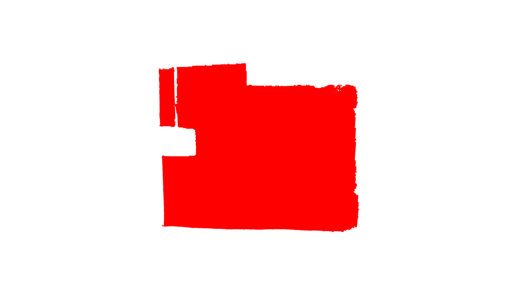

In [ ]:
# Create a PointCloud object from your points (pcd_pts_fitin_plane)
point_cloud = o3d.geometry.PointCloud()

point_cloud.points = o3d.utility.Vector3dVector(pcd_pts_fitin_plane)
point_cloud.paint_uniform_color([1,0,0])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd_original,point_cloud ],
                                  zoom=1,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])




# Save the visualization
save_visualization(point_cloud, pcd_original, save_path="Extracted_points.png")

# Display the saved image in the notebook
img = plt.imread("Extracted_points.png")
plt.imshow(img)
plt.axis("off")  # Turn off axes for a clean image
plt.show()